In [ ]:
import sys
!{sys.executable} -m pip install category_encoders

     |████████████████████████████████| 82 kB 259 kB/s 


In [ ]:
!pip install flaml

     |████████████████████████████████| 160 kB 4.1 MB/s 
     |████████████████████████████████| 2.0 MB 45.6 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [ ]:
#Load data
import pandas as pd
from google.colab import files
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, RobustScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.decomposition import KernelPCA, PCA, TruncatedSVD
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from category_encoders import TargetEncoder
import xgboost as xgb
from scipy.stats import randint, uniform
import lightgbm as lgb

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
uploaded = files.upload()


Saving submission_format.csv to submission_format.csv


In [ ]:
import io 
df = pd.read_csv(io.BytesIO(uploaded['train_values.csv']))

In [ ]:
#Take into dataframe
df_features = df

In [ ]:
df_y = pd.read_csv(io.BytesIO(uploaded['train_labels.csv']))

In [ ]:
df_label = df_y

In [ ]:
df_features['damage_grade'] = df_label['damage_grade']

In [ ]:
#import Test datasets
X_test = pd.read_csv(io.BytesIO(uploaded['test_values.csv']))

In [ ]:
y_test = pd.read_csv(io.BytesIO(uploaded['submission_format.csv']))

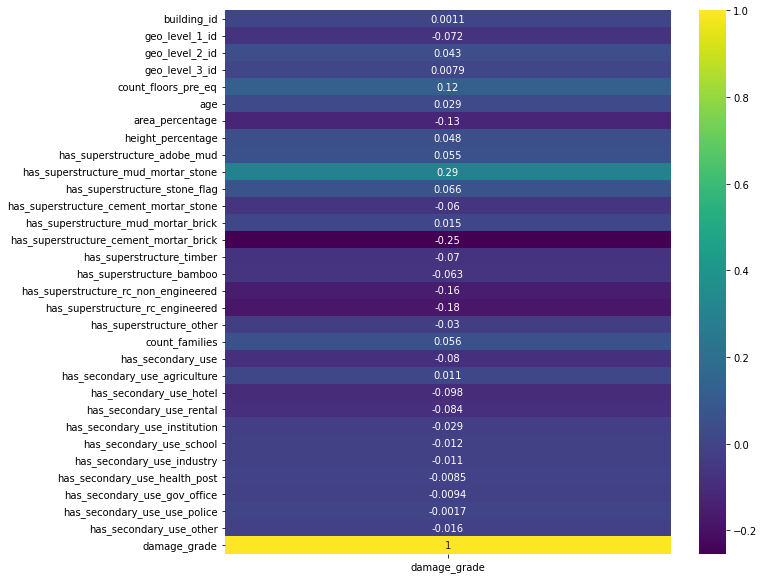

In [ ]:
#Check correlation for all features against the damage grade
plt.figure(figsize=(10,10))
cor=df_features.corr()["damage_grade"]
cor=pd.DataFrame(cor)
sns.heatmap(cor,annot=True,cmap="viridis")

In [ ]:
from sklearn.model_selection import train_test_split

X_train = df_features.drop(['damage_grade'],axis=1)
y_train = df_features['damage_grade']

In [ ]:
df_features.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3


In [ ]:
y_train.head()

0    3
1    2
2    3
3    2
4    3
Name: damage_grade, dtype: int64

In [ ]:
y_test.head()

,building_id,damage_grade
0,300051,1
1,99355,1
2,890251,1
3,745817,1
4,421793,1


In [ ]:
X_train.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_train.shape

(260601, 39)

In [ ]:
y_train.shape

(260601,)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  int64 
 1   geo_level_1_id                          260601 non-null  int64 
 2   geo_level_2_id                          260601 non-null  int64 
 3   geo_level_3_id                          260601 non-null  int64 
 4   count_floors_pre_eq                     260601 non-null  int64 
 5   age                                     260601 non-null  int64 
 6   area_percentage                         260601 non-null  int64 
 7   height_percentage                       260601 non-null  int64 
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260601 non-null 

In [ ]:
#check missing values
X_train.isnull().sum()

building_id                               0
geo_level_1_id                            0
geo_level_2_id                            0
geo_level_3_id                            0
count_floors_pre_eq                       0
age                                       0
area_percentage                           0
height_percentage                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo       

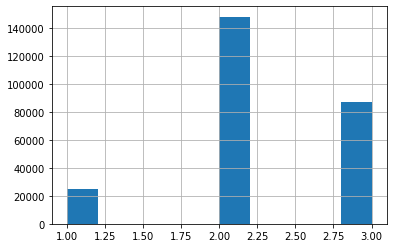

In [ ]:
#check Y variable 
y_train.hist()

In [ ]:
X_train['age']

10     38896
15     36010
5      33697
20     32182
0      26041
25     24366
30     18028
35     10710
40     10559
50      7257
45      4711
60      3612
80      3055
55      2033
70      1975
995     1390
100     1364
65      1123
90      1085
85       847
75       512
95       414
120      180
150      142
200      106
110      100
105       89
125       37
115       21
140        9
130        9
180        7
160        6
170        6
175        5
135        5
145        3
190        3
195        2
165        2
155        1
185        1
Name: age, dtype: int64

In [ ]:
#Deal with Outlier and transform Age
X_train.loc[X_train['age']>50, 'age'] = 50

In [ ]:
#Same for Test
X_test.loc[X_test['age']>50, 'age'] = 50

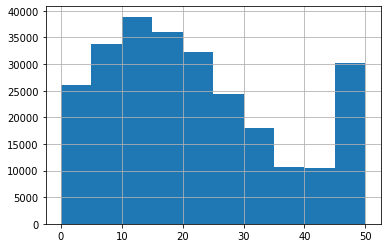

In [ ]:
X_train['age'].hist()

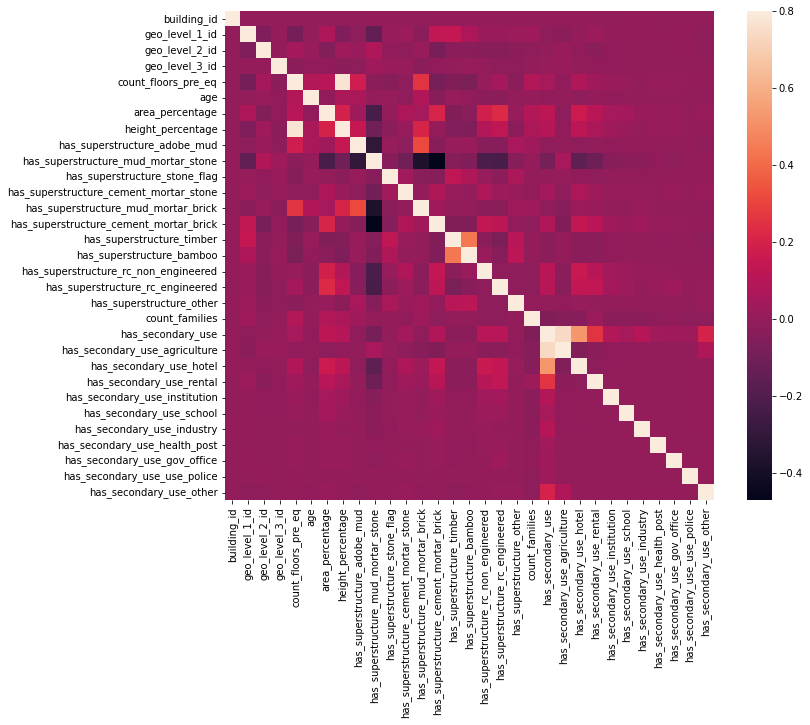

In [ ]:
#correlation matrix
#Found count_floors_pre_eq & height_percentage
corrmat = X_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [ ]:
#Explore categorical Variables
X_train['foundation_type'].value_counts()

r    219196
w     15118
u     14260
i     10579
h      1448
Name: foundation_type, dtype: int64

In [ ]:
#High Cardinality categorical value
X_train['plan_configuration'].value_counts()

d    250072
q      5692
u      3649
s       346
c       325
a       252
o       159
m        46
n        38
f        22
Name: plan_configuration, dtype: int64

In [ ]:
X_train['legal_ownership_status'].value_counts()

v    250939
a      5512
w      2677
r      1473
Name: legal_ownership_status, dtype: int64

In [ ]:
#Feature Engineer - Re-lebel plan_config
from collections import Counter
def cumulatively_categorise(column,threshold=0.96,return_categories_list=True):
  #Find the threshold value using the percentage and number of instances in the column
  threshold_value=int(threshold*len(column))
  #Initialise an empty list for our new minimised categories
  categories_list=[]
  #Initialise a variable to calculate the sum of frequencies
  s=0
  #Create a counter dictionary of the form unique_value: frequency
  counts=Counter(column)

  #Loop through the category name and its corresponding frequency after sorting the categories by descending order of frequency
  for i,j in counts.most_common():
    #Add the frequency to the sum
    s+=dict(counts)[i]
    #Append the category name to the list
    categories_list.append(i)
    #Check if the sum has reached the threshold value, if so break the loop
    if s>=threshold_value:
      break
  
  categories_list.append('Other')

  #Replace all instances not in our new categories by Other  
  new_column=column.apply(lambda x: x if x in categories_list else 'Other')

  #Return transformed column and unique values if return_categories=True
  if(return_categories_list):
    return new_column,categories_list
  #Return only the transformed column if return_categories=False
  else:
    return new_column

#Call the function with a default threshold of 96%
plan_configuration_new,new_plan_list=cumulatively_categorise(X_train['plan_configuration'],return_categories_list=True)


In [ ]:
plan_configuration_new.value_counts()

d        250072
q          5692
Other      4837
Name: plan_configuration, dtype: int64

In [ ]:
X_train['legal_ownership_status'].unique()

array(['v', 'a', 'r', 'w'], dtype=object)

In [ ]:
#Same for X_test
plan_configuration_new_test,new_plan_test_list=cumulatively_categorise(X_test['plan_configuration'],return_categories_list=True)

In [ ]:
#Modify the existing feature
X_train.loc[:,'plan_configuration'] = plan_configuration_new

In [ ]:
#Modify the existing feature for X_test
X_test.loc[:,'plan_configuration'] = plan_configuration_new_test

In [ ]:
#pipleline 1 - Select this one
numeric_features = ['count_floors_pre_eq','age','area_percentage','height_percentage','count_families']

categorical_features = ['land_surface_condition','foundation_type','roof_type','ground_floor_type','other_floor_type','position','plan_configuration','legal_ownership_status',
                        'geo_level_1_id','geo_level_2_id','geo_level_3_id']

drop_features = ['building_id','height_percentage']

clf = lgb.LGBMClassifier(is_unbalance=True)

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ])

categorical_transformer = Pipeline(steps=[
      ('encoder', TargetEncoder(handle_unknown='ignore')),
      ])

preprocessor1 = Pipeline(steps=[
      ('ct', ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            ('drop', 'drop', drop_features)],
            remainder = 'passthrough', 
            sparse_threshold=0)),
      ('feature_selector', SelectKBest(k=35)),
    ])

pipe1 = Pipeline(steps=[('preprocessor', preprocessor1),  ('clf', clf)])

params = {"clf__n_estimators": randint(100,300),
          "clf__max_depth": randint (3, 12),
          "clf__num_leaves": randint(20,3000),
          "clf__min_data_in_leaf": randint(20,500), 
          "clf__learning_rate": uniform(0.01,0.35),
          "clf__feature_fraction": uniform(0, 1),
          "clf__max_bin": randint(50,255),
          "clf__reg_alpha":uniform(0.001,1.000),
          "clf__colsample_bytree":uniform(0.001,1.000),
          "clf__reg_lambda":uniform(0.001,1.000)}


search = RandomizedSearchCV(pipe1, param_distributions=params, n_iter=10, scoring='f1_micro', cv=5, verbose=1)
search = search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] feature_fraction is set=0.29989793731592473, colsample_bytree=0.9225693261778779 will be ignored. Current value: feature_fraction=0.29989793731592473
[LightGBM] [Warning] min_data_in_leaf is set=359, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=359
[LightGBM] [Warning] feature_fraction is set=0.29989793731592473, colsample_bytree=0.9225693261778779 will be ignored. Current value: feature_fraction=0.29989793731592473
[LightGBM] [Warning] min_data_in_leaf is set=359, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=359
[LightGBM] [Warning] feature_fraction is set=0.29989793731592473, colsample_bytree=0.9225693261778779 will be ignored. Current value: feature_fraction=0.29989793731592473
[LightGBM] [Warning] min_data_in_leaf is set=359, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=359
[LightGBM] [Warning] feature_fraction is set=0.2998979

In [ ]:
search.best_params_

{'clf__colsample_bytree': 0.49427902583547345,
 'clf__feature_fraction': 0.461597494817354,
 'clf__learning_rate': 0.35960848561021574,
 'clf__max_bin': 234,
 'clf__max_depth': 9,
 'clf__min_data_in_leaf': 168,
 'clf__n_estimators': 250,
 'clf__num_leaves': 302,
 'clf__reg_alpha': 0.17243947742449806,
 'clf__reg_lambda': 0.29154835978392435}

In [ ]:
#try out#1
numeric_features = ['count_floors_pre_eq','age','area_percentage','height_percentage','count_families']

categorical_features = ['land_surface_condition','foundation_type','roof_type','ground_floor_type','other_floor_type','position','plan_configuration','legal_ownership_status',
                        'geo_level_1_id','geo_level_2_id','geo_level_3_id']

drop_features = ['building_id','height_percentage']

clf = lgb.LGBMClassifier(n_estimators= 285,
                        num_leaves=1100,
                        max_depth=9,
                        learning_rate= 0.19,
                        max_bin= 234,
                        reg_lambda=0.2915483597,
                        colsample_bytree=0.49427902583547345,
                         reg_alpha=0.17243947742449806,
                         feature_fraction=0.461597494817354,
                         min_data_in_leaf=168)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler()),
    ])

categorical_transformer = Pipeline(steps=[
      ('encoder', TargetEncoder(handle_unknown='ignore')),
      ])

preprocessor_test1 = Pipeline(steps=[
      ('ct', ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            ('drop', 'drop', drop_features)],
            remainder = 'passthrough', 
            sparse_threshold=0)),
      ('feature_selector', SelectKBest(k=35)),
    ])

pipe_test1 = Pipeline(steps=[('preprocessor', preprocessor_test1),  ('clf', clf)])


scores_test1 = cross_val_score(pipe_test1, X_train, y_train, scoring='f1_micro', cv=10, n_jobs=-1, error_score="raise")

print(scores_test1)
print(np.mean(scores_test1))

[0.74517478 0.74274751 0.74213354 0.74205679 0.74620107 0.74520338
 0.74435917 0.74182655 0.74623945 0.74036838]
0.7436310622610044


In [ ]:
#try out#2__choose
numeric_features = ['count_floors_pre_eq','age','area_percentage','height_percentage','count_families']

categorical_features = ['land_surface_condition','foundation_type','roof_type','ground_floor_type','other_floor_type','position','plan_configuration','legal_ownership_status',
                        'geo_level_1_id','geo_level_2_id','geo_level_3_id']

drop_features = ['building_id','height_percentage']

clf = lgb.LGBMClassifier(n_estimators= 285,
                        num_leaves=1179,
                        max_depth=10,
                        learning_rate= 0.175,
                        max_bin= 253,
                        reg_lambda=0.38979,
                        colsample_bytree=0.84713,
                         reg_alpha=0.60759,
                         feature_fraction=0.65638,
                         min_data_in_leaf=92)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler()),
    ])

categorical_transformer = Pipeline(steps=[
      ('encoder', TargetEncoder(handle_unknown='ignore')),
      ])

preprocessor_test = Pipeline(steps=[
      ('ct', ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            ('drop', 'drop', drop_features)],
            remainder = 'passthrough', 
            sparse_threshold=0)),
      ('feature_selector', SelectKBest(k=35)),
    ])

pipe_test = Pipeline(steps=[('preprocessor', preprocessor_test),  ('clf', clf)])


scores_test = cross_val_score(pipe_test, X_train, y_train, scoring='f1_micro', cv=10, n_jobs=-1, error_score="raise")

print(scores_test)
print(np.mean(scores_test))

[0.74674801 0.74742901 0.74339985 0.74263239 0.75092095 0.74919417
 0.74850345 0.7453185  0.74930929 0.74804298]
0.7471498589868983


In [ ]:
#Fit and predict 
pipe_test.fit(X_train,y_train)

[LightGBM] [Warning] feature_fraction is set=0.65638, colsample_bytree=0.84713 will be ignored. Current value: feature_fraction=0.65638
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('ct',
                                  ColumnTransformer(remainder='passthrough',
                                                    sparse_threshold=0,
                                                    transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['count_floors_pre_eq',
                                                                    'age',
                                                                    'area_percentage',
                                                       

In [ ]:
#Make Prediction
pre = pipe_test.predict(X_test)

In [ ]:
print(pre)

[3 2 2 ... 2 2 2]


In [ ]:
#Put it into the submission file
y_test.loc[:,'damage_grade'] = pre


In [ ]:
y_test.shape

(86868, 2)

In [ ]:
#save to csv
from google.colab import files
y_test.to_csv('submission_v3.1.csv',index=False, header=True)
files.download('submission_v3.1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>